In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


###  Step 1: Import Required Libraries for Preprocessing

In this step, I imported all the necessary Python libraries required for preprocessing and modeling:

- `pandas` & `numpy`: For handling data structures and numerical operations.
- `seaborn`: For visualizations (optional, used mainly during EDA).
- `train_test_split`: To split the dataset into training and testing sets.
- `StandardScaler`: To normalize/scale numerical features.
- `OneHotEncoder`: To convert categorical variables into numeric format.
- `ColumnTransformer`: To combine transformations for numerical and categorical features.
- `Pipeline`: To streamline preprocessing steps into a clean and modular pipeline.
- `SimpleImputer`: To handle missing values by filling them with mean, median, or mode.
- `SMOTE` from `imblearn`: To handle the class imbalance by oversampling the minority class.
- `Pipeline` from `imblearn`: To combine SMOTE with preprocessing in a single flow.

These libraries will help automate and standardize the preprocessing tasks, making the model-building process more efficient and reproducible.


In [3]:
# Load dataset
df = pd.read_csv("bearing_defects_mixed_dataset.csv")

# Drop timestamp as it's only useful for temporal EDA, not for modeling
df.drop(columns=['timestamp'], inplace=True)


###  Step 2: Load Dataset and Drop Timestamp Column

- I loaded the dataset using `pd.read_csv()` and stored it in a DataFrame named `df`.
- Since I already used the `timestamp` column for time-based EDA earlier, I decided to **drop it** from the dataset for modeling purposes using `df.drop()`.

 Reason for dropping `timestamp`:
- It doesn't provide direct predictive power for the classification task.
- Models work better with structured, numerical, or encoded inputs — and since timestamp wasn't engineered into meaningful features (like "hour", "month", etc.), it's excluded for now.


In [4]:
# Define X and y
X = df.drop("defect", axis=1)
y = df["defect"]

# Check class distribution
print("Target distribution:\n", y.value_counts())


Target distribution:
 defect
0    197910
1      2090
Name: count, dtype: int64


###  Step 3: Define Features and Target and Check Class Imbalance

I separated the dataset into:

- **`X`**: All input features (excluding the target column `defect`)
- **`y`**: The target variable `defect`, which indicates whether a bearing is defective (`1`) or not (`0`)

To inspect the class balance in the target variable, I used `y.value_counts()`.

 The result showed:

- Class `0` (No Defect): 197,910 samples  
- Class `1` (Defect): 2,090 samples

This indicates a **highly imbalanced dataset**, where defective bearings make up only about **1%** of the data. This imbalance needs to be addressed before model training, and I plan to handle it using **SMOTE** (Synthetic Minority Over-sampling Technique).


In [5]:
# Categorical and numerical features
categorical_features = ['material_type', 'machine_type', 'lubrication_type', 'operation_condition', 'maintenance_level']
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in categorical_features]


###  Step 4: Identify Categorical and Numerical Features

In this step, I separated the features into two categories:

- **Categorical features**: Manually listed based on domain knowledge —  
  `material_type`, `machine_type`, `lubrication_type`, `operation_condition`, and `maintenance_level`.

- **Numerical features**: Automatically selected using `select_dtypes()` to include only `int64` and `float64` types.  
  I then filtered out any columns that are in the `categorical_features` list, just to be safe.

This step helps in applying the right preprocessing techniques later — like encoding for categorical variables and scaling for numerical ones.


In [6]:


# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # updated here
])

# Combine both pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


###  Step 5: Build Preprocessing Pipelines

I created two separate pipelines to handle preprocessing for:

- **Numerical features**:
  - Filled missing values using the **median**.
  - Scaled the values using **StandardScaler** for normalization.

- **Categorical features**:
  - Filled missing values with the **most frequent** category.
  - Converted categories into numbers using **OneHotEncoder**, dropping the first to avoid redundancy.

These two pipelines were combined using **ColumnTransformer**, so the right steps are applied to the right columns automatically.


In [7]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


###  Step 6: Split Dataset into Train and Test Sets

I split the dataset into:

- **Training set (80%)**: Used to train the model.
- **Test set (20%)**: Used to evaluate the model's performance on unseen data.

I used `stratify=y` to ensure that both training and test sets maintain the same class distribution as the original dataset — which is important due to the class imbalance.

The `random_state=42` ensures reproducibility of results.


In [8]:
# Build preprocessing and SMOTE pipeline
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42))
])

# Fit and transform X_train
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

# Just transform X_test (no SMOTE)
X_test_proc = preprocessor.transform(X_test)

# Showing class distribution after resampling
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())


Before SMOTE: defect
0    158328
1      1672
Name: count, dtype: int64
After SMOTE: defect
0    158328
1    158328
Name: count, dtype: int64


###  Step 7: Build Preprocessing + SMOTE Pipeline

- An `ImbPipeline` was created to **combine preprocessing and SMOTE** into one seamless step:
  - `'preprocess'`: Applies transformations defined earlier (imputation, scaling, encoding).
  - `'smote'`: Applies SMOTE (Synthetic Minority Over-sampling Technique) to balance the imbalanced dataset by synthetically generating samples for the minority class.

- `X_train` and `y_train` were passed through `.fit_resample()`:
  - **Preprocessing was applied**
  - **SMOTE oversampled the minority class**

- `X_test` was only transformed (not resampled) using the preprocessor.

####  Class Distribution Before and After SMOTE:
- **Before SMOTE**:
  - Class `0`: 158,328 samples
  - Class `1`: 1,672 samples
- **After SMOTE**:
  - Both Class `0` and `1` now have **158,328 samples each**, indicating perfect class balance.

This step helps improve the model's ability to learn from rare defect cases (minority class).


Text(0.5, 1.0, 'Class Distribution After SMOTE')

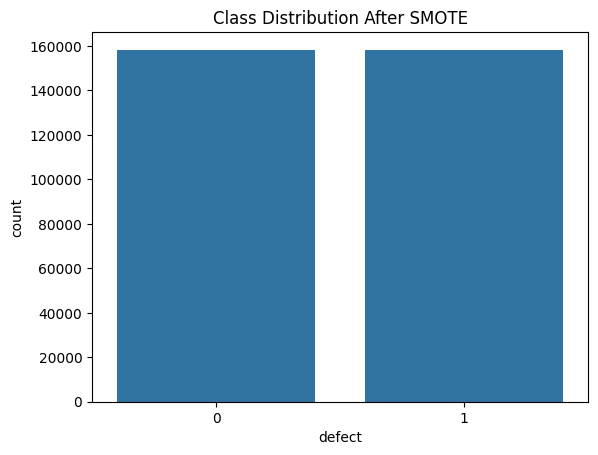

In [9]:
#To double-check, we could visualize it:
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")


###  Observation: Class Distribution After SMOTE

The bar plot shows that both classes — defect = 0 (no defect) and defect = 1 (defect) — now have an equal number of samples after applying SMOTE. This confirms that the class imbalance issue has been resolved. The balanced distribution ensures that the model will not be biased toward the majority class and will have equal opportunity to learn patterns from both defect and non-defect cases.


In [10]:
# Save preprocessed numpy arrays if needed
np.save("X_train_res.npy", X_train_res)
np.save("y_train_res.npy", y_train_res)
np.save("X_test_proc.npy", X_test_proc)
np.save("y_test.npy", y_test.to_numpy())


###  Saving Preprocessed Data

The preprocessed training and testing datasets are saved as `.npy` (NumPy array) files using `np.save()`. This is useful for quickly reloading the data later without repeating preprocessing steps like scaling, encoding, and SMOTE. 

- `X_train_res.npy` and `y_train_res.npy` store the resampled (balanced) training features and labels.
- `X_test_proc.npy` contains the transformed testing features.
- `y_test.npy` saves the original test labels as a NumPy array.

This step enhances reproducibility and speeds up future model training.


###  Preprocessing Summary

1. **Library Imports**  
   Imported all required libraries for data handling, preprocessing, visualization, and handling class imbalance.

2. **Data Loading and Cleaning**  
   - Loaded the dataset using `pd.read_csv()`.
   - Dropped the `timestamp` column since it’s not directly useful for modeling.

3. **Feature and Target Separation**  
   - Defined `X` as input features and `y` as the target (`defect`).
   - Observed a class imbalance, with very few defective cases compared to non-defective ones.

4. **Feature Classification**  
   - Identified and separated **categorical** and **numerical** columns for proper preprocessing.

5. **Pipeline Construction**  
   - Built preprocessing pipelines:
     - **Numerical**: Filled missing values with median, scaled features.
     - **Categorical**: Filled missing values with most frequent values, then applied one-hot encoding.
   - Combined both using `ColumnTransformer`.

6. **Train-Test Split**  
   - Split data into training (80%) and testing (20%) sets.
   - Used `stratify=y` to maintain class proportions in both sets.

7. **Class Imbalance Handling with SMOTE**  
   - Applied SMOTE only to training data to synthetically balance classes.
   - Verified balance using count plot.

8. **Saving Preprocessed Data**  
   - Saved preprocessed training and testing sets as `.npy` files for easy reuse without repeating preprocessing.

 The preprocessing ensures clean, balanced, and ready-to-use data for model training and evaluation.
